### Zadanie rekrutacyjne - Product Analyst Otodom 
### Agnieszka Spychała

In [38]:
import sqlite3
import pandas as pd
import datetime as dt
from datetime import date
import calendar
import matplotlib.pyplot as plt
import numpy as np
import operator as op
import seaborn as sns
import re
from collections import Counter
from functools import reduce

##### Utworzenie bazy danych w SQLite

In [2]:
conn = sqlite3.connect('sql.db')

In [3]:
cursor = conn.cursor()

##### Wczytanie plików wejściowych csv


In [4]:
ads = pd.read_csv('data_ads.csv', sep=';', names = ['date','user_id','ad_id','category_id','params'])
ads['date'] = pd.to_datetime(ads['date'])
ads['day_of_week'] = ads['date'].dt.day_name()
replies = pd.read_csv('data_replies.csv', sep=';', names=["date", "user_id", "ad_id", "mails", "phones"])
replies = replies.fillna(0)
replies['date'] = pd.to_datetime(replies['date'])
replies['phones'] = replies['phones'].astype(int)
cat = pd.read_csv('data_categories.csv', sep=';', names=["category_id", "category_name"])
seg = pd.read_csv('data_segments.csv', sep=';', names=["user_id", "segment"])

In [142]:
ads

,date,user_id,ad_id,category_id,params,day_of_week
0,2019-04-02,2467510,58563324,102,price<=>price<br>price<=>3100<br>price[currenc...,Tuesday
1,2019-04-02,530533,58563976,401,price<=>price<br>price<=>360000<br>price[curre...,Tuesday
2,2019-04-03,131944,58571784,201,price<=>price<br>price<=>288000<br>price[curre...,Wednesday
3,2019-04-03,772713,58581708,101,price<=>price<br>price<=>495000<br>price[curre...,Wednesday
4,2019-04-07,190178,58632504,101,price<=>price<br>price<=>210000<br>price[curre...,Sunday
5,2019-04-08,2297140,58652084,101,price<=>price<br>price<=>450000<br>price[curre...,Monday
6,2019-04-08,2297140,58652128,101,price<=>price<br>price<=>500000<br>price[curre...,Monday
7,2019-04-09,2992683,58665624,401,price<=>price<br>price<=>350000<br>price[curre...,Tuesday
8,2019-04-09,2917026,58666912,401,price<=>price<br>price<=>15500000<br>price[cur...,Tuesday
9,2019-04-09,849803,58668544,102,price<=>price<br>price<=>1800<br>price[currenc...,Tuesday


##### Import wczytanych plików csv do bazy danych

In [6]:
ads.to_sql('ads', conn, if_exists='replace', index=False)
replies.to_sql('replies', conn, if_exists='replace', index=False)
cat.to_sql('cat', conn, if_exists='replace', index=False)
seg.to_sql('seg', conn, if_exists='replace', index=False)

##### Wyliczenie wskaźnika liquidity

In [7]:
query = """
SELECT user_id, sum(within_week) / CAST(count(*) AS float) as liquidity
FROM (
    SELECT ads.ad_id as ad_id, ads.user_id as user_id, COALESCE(MIN(replies.date) < date(ads.date, "+7 days"), 0) as within_week
    FROM ads LEFT JOIN replies ON ads.ad_id = replies.ad_id AND (replies.phones + replies.mails) > 0
    GROUP BY ads.ad_id, ads.user_id
)
GROUP BY user_id
"""
cursor.execute(query)
liquidity = dict(cursor.fetchall())

In [8]:
liquidity

{99: 0.75,
 3747: 0.6153846153846154,
 10717: 0.6,
 14738: 0.26666666666666666,
 23034: 1.0,
 23432: 0.6666666666666666,
 28452: 0.75,
 42206: 0.2857142857142857,
 45456: 1.0,
 49637: 1.0,
 57981: 0.0,
 60700: 0.14285714285714285,
 60940: 0.375,
 68673: 0.3902439024390244,
 77328: 0.75,
 83151: 0.0,
 86196: 0.5,
 98373: 0.08333333333333333,
 101214: 0.6666666666666666,
 111337: 0.3305084745762712,
 120050: 0.42857142857142855,
 126728: 0.6,
 131944: 0.22727272727272727,
 136206: 0.5,
 145719: 0.5,
 147364: 0.5,
 159454: 0.3333333333333333,
 164255: 1.0,
 169748: 0.35,
 190178: 0.7333333333333333,
 206605: 0.4722222222222222,
 242528: 0.0,
 248382: 0.25,
 254988: 0.48484848484848486,
 257070: 0.8333333333333334,
 294906: 0.0,
 300040: 1.0,
 311180: 0.5277777777777778,
 313735: 0.5,
 315086: 0.7142857142857143,
 353522: 0.30434782608695654,
 382657: 0.5833333333333334,
 399255: 0.4,
 407922: 0.5925925925925926,
 427353: 0.3333333333333333,
 429895: 0.6666666666666666,
 430231: 0.33333333

##### Wyliczenie wskaźnika liquidity dla poszczególnych kategorii

In [9]:
query = """
SELECT category_id, sum(within_week) / CAST(count(*) AS float) as liquidity
FROM (
    SELECT ads.ad_id as ad_id, ads.category_id as category_id, COALESCE(MIN(replies.date) < date(ads.date, "+7 days"), 0) as within_week
    FROM ads LEFT JOIN replies ON ads.ad_id = replies.ad_id AND (replies.phones + replies.mails) > 0
    GROUP BY ads.ad_id, ads.category_id
)
GROUP BY category_id
"""
cursor.execute(query)
cat_liq = dict(cursor.fetchall())

In [10]:
cat

,category_id,category_name
0,1,na sprzedaż
1,2,na wynajem
2,11,Inwestycje
3,21,Projekty
4,101,Mieszkania na sprzedaż
5,102,Mieszkania na wynajem
6,201,Domy na sprzedaż
7,202,Domy na wynajem
8,302,Pokoje na wynajem
9,401,Działki na sprzedaż


In [341]:
cat_liq


{101: 0.38179952104002735,
 102: 0.5439838220424671,
 201: 0.46444780635400906,
 202: 0.37254901960784315,
 302: 1.0,
 401: 0.2753623188405797,
 402: 0.3333333333333333,
 501: 0.2727272727272727,
 502: 0.2254335260115607,
 601: 0.2222222222222222,
 602: 0.24242424242424243,
 701: 0.5,
 702: 0.0}

In [344]:
plt.figure(figsize=(8,8))
sns.barplot(list(cat_liq.values()), cat(cat['category_id'].isin(list(cat_liq.keys())))['category_name'])
#plt.bar(cat[cat['category_id'].isin(cat_liq.keys())]['category_name'], height = list(cat_liq.values()))
plt.xticks(rotation='vertical')
plt.title("Wartość wskaźnika liquidity dla kategorii ogłoszeń", fontsize=25)
plt.show()

TypeError: 'DataFrame' object is not callable

<Figure size 576x576 with 0 Axes>

In [13]:
print(ads.groupby(['category_id'])['category_id'].count(), cat)

category_id
101    2923
102     989
201     661
202      51
302       2
401     414
402       3
501      77
502     346
601       9
602      66
701       4
702       1
Name: category_id, dtype: int64     category_id                category_name
0             1                  na sprzedaż
1             2                   na wynajem
2            11                   Inwestycje
3            21                     Projekty
4           101       Mieszkania na sprzedaż
5           102        Mieszkania na wynajem
6           201             Domy na sprzedaż
7           202              Domy na wynajem
8           302            Pokoje na wynajem
9           401          Działki na sprzedaż
10          402           Działki na wynajem
11          501  Lokale użytkowy na sprzedaż
12          502   Lokale użytkowy na wynajem
13          601    Hale/Magazyny na sprzedaż
14          602     Hale/Magazyne na wynajem
15          701           Garaże na sprzedaż
16          702            Garaże n

Widoczna jest zależność pomiędzy wartością wskaźnika liquidity, a kategorią ogłoszenia. Trudno jednoznacznie określić, które kategorie ogłoszeń są chętniej przeglądane przez klientów, z uwagi na niewielką liczbę ogłoszeń, w niektórych kategoriach. Np. dla kategorii "Pokoje na wynajem" liquidity wg danych wynosi 100%, jednak liczba ogłoszeń to tylko 2, a dla kategorii "Garaże na wynajem" liquidity jest równe 0%, jednak zamieszczono tylko jedno ogłoszenie. Jednak biorąc pod uwagę tylko kategorie, w których zamieszczono co najmniej 300 ogłoszeń wg dostępnych danych największą wartość liquidity (54%) osiągnęła kategoria "Mieszkania na wynajem". Natomiast wartość analizowanego współczynnika była najmniejsza dla kategorii "Lokale użytkowe na wynajem" i wynosiła tylko 22%.

##### Rozkład wskaźnika liquidity dla poszczególnych segmentów

In [14]:
seg_mapping = dict(list(zip(seg['user_id'], seg['segment'])))

In [15]:
seg_liq = {'Beginners': [], 'Sharks': [], 'Hipot': []}
for k,v in liquidity.items():
    seg_liq[seg_mapping[k]].append(v)

In [304]:
labels, data = seg_liq.keys(), seg_liq.values()
labels

dict_keys(['Beginners', 'Sharks', 'Hipot'])

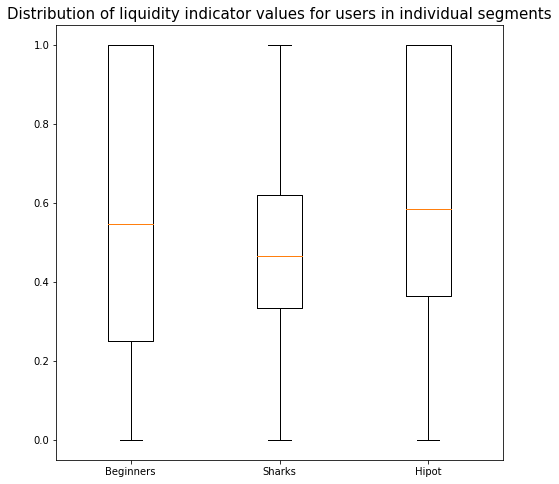

In [307]:

plt.figure(figsize=(8,8))
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title("Distribution of liquidity indicator values for users in individual segments" , fontsize=15)
plt.savefig('segments.png')
plt.show()

In [17]:
df_beg = pd.DataFrame.from_dict(seg_liq['Beginners'])
df_sha = pd.DataFrame.from_dict(seg_liq['Sharks'])
df_hip = pd.DataFrame.from_dict(seg_liq['Hipot'])
df_beg.describe()

,0
count,134.000000
mean,0.553674
std,0.355836
min,0.000000
25%,0.250000
50%,0.545455
75%,1.000000
max,1.000000


In [18]:
df_sha.describe()

,0
count,111.000000
mean,0.487204
std,0.240600
min,0.000000
25%,0.333333
50%,0.466667
75%,0.620192
max,1.000000


In [19]:
df_hip.describe()

,0
count,89.000000
mean,0.598238
std,0.317516
min,0.000000
25%,0.363636
50%,0.583333
75%,1.000000
max,1.000000


In [20]:
seg_users = {'Beginners': [], 'Sharks': [], 'Hipot': []}
for k,v in seg_mapping.items():
    seg_users[seg_mapping[k]].append(k)

In [22]:
query = """
SELECT  seg.segment, count(*) as ad_count
FROM ads
INNER JOIN seg ON ads.user_id=seg.user_id
GROUP BY seg.segment 
"""
cursor.execute(query)
seg_ad_count = dict(cursor.fetchall())

In [23]:
seg_ad_count

{'Beginners': 858, 'Hipot': 535, 'Sharks': 4153}

In [24]:
query = """
SELECT  segment, count(*) 
FROM seg
GROUP BY segment 
"""
cursor.execute(query)
seg_count = dict(cursor.fetchall())

In [25]:
seg_count

{'Beginners': 178, 'Hipot': 111, 'Sharks': 116}

In [26]:
seg_mean = dict((k, float(seg_ad_count[k]) / seg_count[k]) for k in seg_ad_count)
seg_mean

{'Beginners': 4.820224719101123,
 'Hipot': 4.81981981981982,
 'Sharks': 35.80172413793103}

W zbiorze danych istnieją 3 segmenty użytkowników: Beginners, Sharks oraz Hipot. Najwięcej użytkowników jest w segmencie Beginners - 178, w segmencie Sharks jest 116 użytkowników, a w segmencie Hipot 111, z czego w dostępnej bazie danych ogłoszenia wystawiane były przez odpowiednio 134, 111 i 89 użytkowników w poszczególnych segmentach. Rozkłady wartości wskaźnika liquidity dla użytkowników z segmentów Beginners oraz Hipot są bardzo zbliżone do siebie. Średnie dla tych segmentów wynoszą powyżej 50%, natomiast różnice między trzecim i pierwszym kwartylem obejmują szeroki zakres rozkładów - dla Beginners są to wartości pomiędzy 25% a 100 %, a dla Hipot pomiędzy 36% a 100%. Natomiast segment użytkowników Shark znacząco różni się od pozostałych dwóch. Średnia w tym przypadku jest niższa od 50%, a wartości pomiędzy trzecim i pierwszym kwartylem obejmują dużo mniejszy przedział niż pozostałych dwóch segmentach - od 33% do 62%. Niewątpliwie wpływ na gorsze statystyki dla segmentu Sharks ma fakt, iż użytkownicy z tej grupy wystawiali znacznie więcej ogłoszeń niż w pozostałych 2 grupach i było to średnio prawie 36 ogłoszeń na użytkownika. W segmentach Beginner i Hipot średnia liczba ogłoszeń umieszczanych przez użytkowników wynosiła tylko około 5. Segment użytkownika może być kolejnym istotnym czynnikiem determinującym wartość wskaźnika liquidity. Z dostępnych danych wynika, iż użytkownicy z segmentu Shark umieszczają średnio najwięcej ogłoszeń, jednak statystycznie osiągają one najgorsze wyniki, jeśli chodzi o liczbę wyświetleń w pierwszym tygodniu. Segment Sharks jest to najbardziej aktywna grupa użytkowników. Największe szanse na wysoką wartość wskaźnika mają użytkownicy z segmentu Hipot. Prawdopodobnie ogłoszenia dodawane przez sprzedawców z grupy Hipot są lepiej odbierane przez klientów niż te umieszczane przez grupę Beginners, dzięki większemu doświadczeniu w sprzedaży tej grupy użytkowników.

##### Wpływ dni tygodni, w których umieszczane są ogłoszenia na wartość liquidity

In [345]:
replies['date'] = pd.to_datetime(replies['date'])
replies['day_of_week'] = replies['date'].dt.day_name()
replies['sum'] = replies['mails'] + replies['phones'].astype(int)

day_of_week
Friday       4989
Monday       8732
Saturday     3477
Sunday       5951
Thursday     5917
Tuesday      8136
Wednesday    6315
Name: sum, dtype: int64


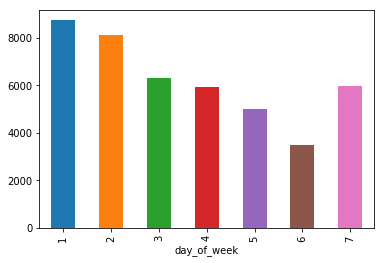

In [346]:
rep_days = replies.groupby(['day_of_week'], as_index = False).sum()
days = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday': 4, 'Friday': 5,
                                            'Saturday': 6, 'Sunday': 7}
s = rep_days['day_of_week'].apply(lambda x: days[x])
s.sort_values()
rep_days.set_index(s.sort_index()).sort_index()['sum'].plot.bar(x='day_of_week', y='sum')
print(replies.groupby(['day_of_week'])['sum'].sum())

Z powyższego wykresu wynika, iż najwięcej odpowiedzi na ogłoszenia udzielanych jest w poniedziałki. Liczba odpowiedzi stopniowo spada w ciągu tygodnia - najmniej odpowiedzi wysłano w soboty. W niedziele odpowiedzi na ogłoszenia było więcej niż w soboty.

##### Wyliczenie wskaźnika liquidity w zależności od dnia, w którym umieszczono ogłoszenie

In [347]:
query = """
SELECT day_of_week, sum(within_week) / CAST(count(*) AS float) as liquidity
FROM (
    SELECT ads.ad_id as ad_id, ads.day_of_week as day_of_week, COALESCE(MIN(replies.date) < date(ads.date, "+7 days"), 0) as within_week
    FROM ads LEFT JOIN replies ON ads.ad_id = replies.ad_id AND (replies.phones + replies.mails) > 0
    GROUP BY ads.ad_id, ads.day_of_week
)
GROUP BY day_of_week
"""
cursor.execute(query)
ads_days_liq = dict(cursor.fetchall())

In [348]:
ads_dict = {'Days Liquidity' : ads_days_liq}
list_ = ads_days_liq.items()
mapping = {'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}

new_list = list(zip(list_,[mapping[i[0]] for i in list_]))
new_list.sort(key=op.itemgetter(1))
ads_list = []
for i in range(len(new_list)):
    ads_list.append(new_list[i][0])

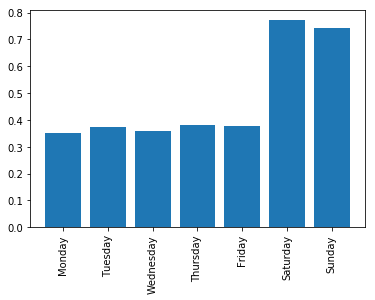

In [350]:
plt.bar(ads_dict.keys(), height = list(ads_dict.values()))
plt.xticks(rotation='vertical')
plt.show()

In [349]:
ads_dict = dict(ads_list)
ads_dict

{'Monday': 0.35190918472652216,
 'Tuesday': 0.37337413925019125,
 'Wednesday': 0.36023622047244097,
 'Thursday': 0.3827859569648924,
 'Friday': 0.3783209351753454,
 'Saturday': 0.7715355805243446,
 'Sunday': 0.7423312883435583}

In [49]:
prmt = ads.copy()

In [42]:
par_columns = []
def split1(data):
    par = data['params']
    for i in range(0, (len(par)-1)):
        temp = par[i]
        temp = temp.split('<br>')
        temp.remove('price<=>price')
        for j in range(0, (len(temp)-1)):
            names = temp[j].split('<=>')
            par_columns.append(names[0])
            
            

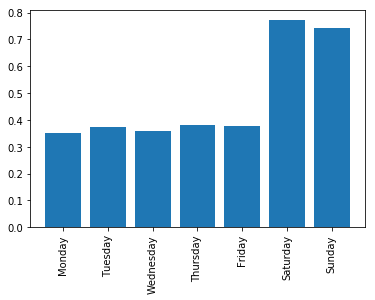

In [353]:
plt.bar(ads_dict.keys(), height = list(ads_dict.values()))
plt.xticks(rotation='vertical')
plt.title("Liquidity value due to the day of the week, on which the ad was published")
plt.show()

In [351]:
ads_days_liq

{'Friday': 0.3783209351753454,
 'Monday': 0.35190918472652216,
 'Saturday': 0.7715355805243446,
 'Sunday': 0.7423312883435583,
 'Thursday': 0.3827859569648924,
 'Tuesday': 0.37337413925019125,
 'Wednesday': 0.36023622047244097}

Z powyżej tabeli wynika, iż wskaźnik liquidity jest znacząco większy dla ogłoszeń umieszczanych w soboty oraz niedziele od wartości wskaźnika dla ogłoszeń umieszczanych od poniedziałku do piątku. Można zatem stwierdzić, iż dzień tygodnia, w którym umieszczane są ogłoszenia ma istotny wpływ na wartość wskaźnika liquidity. 

In [43]:
splited = split1(prmt)

In [44]:
par_columns
c = Counter(par_columns)
columns = reduce(lambda l, x: l+[x] if x not in l else l, par_columns, [])
columns

['price',
 'price[currency]',
 'rent',
 'rent[currency]',
 'deposit',
 'deposit[currency]',
 'm',
 'rooms_num',
 'building_type',
 'floor_no',
 'building_floors_num',
 'building_material',
 'windows_type',
 'heating',
 'build_year',
 'construction_status',
 'free_from',
 'rent_to_students',
 'equipment_types',
 'security_types',
 'media_types',
 'price_per_m',
 'type',
 'dimensions',
 'fence',
 'location',
 'access_types',
 'terrain_area',
 'market',
 'floors_num',
 'garret_type',
 'roof_type',
 'roofing',
 'recreational',
 'fence_types',
 'heating_types',
 'vicinity_types',
 'extras_types',
 'building_ownership',
 'use_types',
 'height',
 'structure',
 'parking',
 'flooring',
 'office_space',
 'social_facilities',
 'ramp',
 'localization',
 'lighting',
 'roomsize',
 'non_smokers_only']

In [ ]:
for i in columns:
    prmt[i] = 0

In [138]:
def fill_columns(data):
    par = data['params']
    #check = data.isin(L)
    for i in range(0, (len(par)-1)):
        temp = par[i]
        temp = temp.split('<br>')
        temp.remove('price<=>price')
        for j in range(0, (len(temp)-1)):
            values = temp[j].split('<=>')
            if (str(values[0]) in columns):
                value1 = values[1]
                print(value1)
                data = data.append({values[0]: value1}, ignore_index=True)
                #L.append(values[1])
                #data = pd.DataFrame(L, columns=[str(values[0])])
                #L.clear()  
            

In [309]:
def fill_column(data, string):
    par = data['params']
    new_column = data[string]
    n = 0
    m = 0
    for i in range(0, (len(par)-1)):
        temp = par[i]
        temp = temp.split('<br>')
        temp.remove('price<=>price')
        for j in range(0, (len(temp))):
            values = temp[j].split('<=>')
            if (values[0] == string):
                value1 = values[1]
                new_column[n] = value1
                n = n + 1
                m = m + 1
            

In [ ]:
fill_column(prmt, 'price')

In [310]:
for i in columns:
    fill_column(prmt, i)

/home/agnieszka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/agnieszka/.local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


KeyboardInterrupt: 

In [204]:
prmt

,date,user_id,ad_id,category_id,params,day_of_week,price,price[currency],rent,rent[currency],...,structure,parking,flooring,office_space,social_facilities,ramp,localization,lighting,roomsize,non_smokers_only
0,2019-04-02,2467510,58563324,102,price<=>price<br>price<=>3100<br>price[currenc...,Tuesday,3100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-04-02,530533,58563976,401,price<=>price<br>price<=>360000<br>price[curre...,Tuesday,360000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-04-03,131944,58571784,201,price<=>price<br>price<=>288000<br>price[curre...,Wednesday,288000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-04-03,772713,58581708,101,price<=>price<br>price<=>495000<br>price[curre...,Wednesday,495000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-04-07,190178,58632504,101,price<=>price<br>price<=>210000<br>price[curre...,Sunday,210000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2019-04-08,2297140,58652084,101,price<=>price<br>price<=>450000<br>price[curre...,Monday,450000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2019-04-08,2297140,58652128,101,price<=>price<br>price<=>500000<br>price[curre...,Monday,500000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2019-04-09,2992683,58665624,401,price<=>price<br>price<=>350000<br>price[curre...,Tuesday,350000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2019-04-09,2917026,58666912,401,price<=>price<br>price<=>15500000<br>price[cur...,Tuesday,15500000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2019-04-09,849803,58668544,102,price<=>price<br>price<=>1800<br>price[currenc...,Tuesday,1800,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [235]:
query = """
SELECT replies.ad_id, EXISTS(
    SELECT * 
    FROM ads LEFT JOIN replies ON ads.ad_id = replies.ad_id AND (replies.phones + replies.mails) > 0
    WHERE (COALESCE(ads.date < date(ads.date, "+7 days"), 0)))
FROM replies

"""
cursor.execute(query)
reply = cursor.fetchall()

In [247]:
reply

[(57528756, 1),
 (58235200, 1),
 (46404076, 1),
 (57132008, 1),
 (56033268, 1),
 (57490308, 1),
 (48048242, 1),
 (57358816, 1),
 (58441728, 1),
 (58141032, 1),
 (47257966, 1),
 (58333844, 1),
 (58253120, 1),
 (54599124, 1),
 (33440289, 1),
 (42805113, 1),
 (57178396, 1),
 (58096560, 1),
 (58229564, 1),
 (55482092, 1),
 (57425992, 1),
 (58214640, 1),
 (50589192, 1),
 (57419492, 1),
 (53047167, 1),
 (55014652, 1),
 (57930064, 1),
 (54732620, 1),
 (58118012, 1),
 (42793767, 1),
 (57667288, 1),
 (57721400, 1),
 (56183344, 1),
 (58085284, 1),
 (55386804, 1),
 (58166556, 1),
 (54934512, 1),
 (58477828, 1),
 (54073572, 1),
 (58458248, 1),
 (58501948, 1),
 (55589436, 1),
 (45821028, 1),
 (58199764, 1),
 (58392304, 1),
 (55630912, 1),
 (57605856, 1),
 (57745584, 1),
 (57385096, 1),
 (48046350, 1),
 (55147020, 1),
 (56020368, 1),
 (34847367, 1),
 (57089204, 1),
 (57931132, 1),
 (57476512, 1),
 (58306552, 1),
 (54815284, 1),
 (49204594, 1),
 (57620696, 1),
 (58158008, 1),
 (58086136, 1),
 (543209

In [248]:
reply_list = []
for i in range(0, len(reply)):
    reply_list.append(reply[i][0])
reply_list

[57528756,
 58235200,
 46404076,
 57132008,
 56033268,
 57490308,
 48048242,
 57358816,
 58441728,
 58141032,
 47257966,
 58333844,
 58253120,
 54599124,
 33440289,
 42805113,
 57178396,
 58096560,
 58229564,
 55482092,
 57425992,
 58214640,
 50589192,
 57419492,
 53047167,
 55014652,
 57930064,
 54732620,
 58118012,
 42793767,
 57667288,
 57721400,
 56183344,
 58085284,
 55386804,
 58166556,
 54934512,
 58477828,
 54073572,
 58458248,
 58501948,
 55589436,
 45821028,
 58199764,
 58392304,
 55630912,
 57605856,
 57745584,
 57385096,
 48046350,
 55147020,
 56020368,
 34847367,
 57089204,
 57931132,
 57476512,
 58306552,
 54815284,
 49204594,
 57620696,
 58158008,
 58086136,
 54320984,
 54041720,
 57480180,
 56810540,
 48050990,
 57151676,
 58460072,
 57893320,
 44467652,
 53576808,
 55394876,
 56204984,
 58216316,
 58331376,
 46686670,
 57236196,
 58176028,
 56876748,
 57378688,
 47488554,
 53865784,
 57682192,
 55676588,
 57809564,
 58236300,
 58477664,
 58332976,
 55343388,
 42630203,

In [275]:
for i in range(len(prmt['ad_id'])):
    print (i)
    if prmt['ad_id'][i] in reply_list:
        prmt['reply'][i] = 1
    else: prmt['reply'][i] = 0

0
1
2


/home/agnieszka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


/home/agnieszka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560


3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199


4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839


TypeError: 0 is not a string

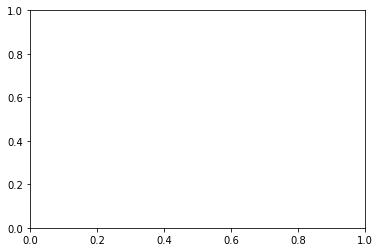

In [288]:
plt.plot(prmt.price, prmt.reply)
plt.show()

In [ ]:
def fill_columns(data):
    par = data['params']
    #L  = []
    #check = data.isin(L)
    for i in range(0, (len(par)-1)):
        temp = par[i]
        temp = temp.split('<br>')
        temp.remove('price<=>price')
        for j in range(0, (len(temp)-1)):
            values = temp[j].split('<=>')
            if (str(values[0]) in data and isinstance(values[1], int) == True):
                data[str(values[0])].append(values[1])
                print(values[1])
            #elif(str(values[0]) in data and type(values[1]) == str):
                #L.append(values[1])
                #data = pd.DataFrame(L, columns=[str(values[0])])
                #L.clear()                print(values[1])

In [364]:
prmt['price'] = pd.to_numeric(prmt['price'])
prmt.dtypes

date                   datetime64[ns]
user_id                         int64
ad_id                           int64
category_id                     int64
params                         object
day_of_week                    object
price                         float64
price[currency]                object
rent                            int64
rent[currency]                  int64
deposit                         int64
deposit[currency]               int64
m                               int64
rooms_num                       int64
building_type                   int64
floor_no                        int64
building_floors_num             int64
building_material               int64
windows_type                    int64
heating                         int64
build_year                      int64
construction_status             int64
free_from                       int64
rent_to_students                int64
equipment_types                 int64
security_types                  int64
media_types 

In [356]:
corr = prmt.corr(method = 'pearson')
print(corr)

                      user_id     ad_id  category_id  rent  rent[currency]  \
user_id              1.000000 -0.081375    -0.064896   NaN             NaN   
ad_id               -0.081375  1.000000    -0.026364   NaN             NaN   
category_id         -0.064896 -0.026364     1.000000   NaN             NaN   
rent                      NaN       NaN          NaN   NaN             NaN   
rent[currency]            NaN       NaN          NaN   NaN             NaN   
deposit                   NaN       NaN          NaN   NaN             NaN   
deposit[currency]         NaN       NaN          NaN   NaN             NaN   
m                         NaN       NaN          NaN   NaN             NaN   
rooms_num                 NaN       NaN          NaN   NaN             NaN   
building_type             NaN       NaN          NaN   NaN             NaN   
floor_no                  NaN       NaN          NaN   NaN             NaN   
building_floors_num       NaN       NaN          NaN   NaN      

In [370]:
prmt['price'].corr(prmt['reply'])

-0.0003395785773498718